episode: 0/200000, thread: 0, score: 14.0, average: 14.00 
episode: 1/200000, thread: 0, score: 23.0, average: 18.50 
episode: 2/200000, thread: 0, score: 18.0, average: 18.33 
episode: 3/200000, thread: 0, score: 11.0, average: 16.50 
episode: 4/200000, thread: 0, score: 32.0, average: 19.60 
episode: 5/200000, thread: 0, score: 13.0, average: 18.50 
episode: 6/200000, thread: 0, score: 19.0, average: 18.57 
episode: 7/200000, thread: 0, score: 12.0, average: 17.75 
episode: 8/200000, thread: 0, score: 11.0, average: 17.00 
episode: 9/200000, thread: 0, score: 27.0, average: 18.00 
episode: 10/200000, thread: 0, score: 15.0, average: 17.73 
episode: 11/200000, thread: 0, score: 9.0, average: 17.00 
episode: 12/200000, thread: 0, score: 21.0, average: 17.31 
episode: 13/200000, thread: 0, score: 22.0, average: 17.64 
episode: 14/200000, thread: 0, score: 10.0, average: 17.13 
episode: 15/200000, thread: 0, score: 21.0, average: 17.38 
episode: 16/200000, thread: 0, score: 12.0, average

episode: 137/200000, thread: 1, score: 22.0, average: 36.04 
episode: 138/200000, thread: 2, score: 29.0, average: 36.28 
episode: 139/200000, thread: 0, score: 24.0, average: 36.34 
episode: 140/200000, thread: 3, score: 23.0, average: 36.26 
episode: 141/200000, thread: 3, score: 17.0, average: 35.88 
episode: 142/200000, thread: 2, score: 30.0, average: 35.54 
episode: 143/200000, thread: 0, score: 39.0, average: 35.56 
episode: 144/200000, thread: 2, score: 27.0, average: 35.44 
episode: 145/200000, thread: 2, score: 14.0, average: 34.88 
episode: 146/200000, thread: 3, score: 58.0, average: 35.56 
episode: 147/200000, thread: 1, score: 96.0, average: 37.00 
episode: 148/200000, thread: 0, score: 72.0, average: 38.08 
episode: 149/200000, thread: 1, score: 23.0, average: 38.16 
episode: 150/200000, thread: 0, score: 36.0, average: 38.26 
episode: 151/200000, thread: 2, score: 78.0, average: 39.08 
episode: 152/200000, thread: 0, score: 25.0, average: 39.12 
episode: 153/200000, thr

episode: 270/200000, thread: 0, score: 200.0, average: 174.28 
episode: 271/200000, thread: 2, score: 200.0, average: 174.28 
episode: 272/200000, thread: 1, score: 135.0, average: 172.98 
episode: 273/200000, thread: 3, score: 200.0, average: 173.08 
episode: 274/200000, thread: 0, score: 200.0, average: 173.08 
episode: 275/200000, thread: 2, score: 170.0, average: 175.72 
episode: 276/200000, thread: 1, score: 123.0, average: 176.44 
episode: 277/200000, thread: 0, score: 166.0, average: 178.30 
episode: 278/200000, thread: 3, score: 168.0, average: 177.66 
episode: 279/200000, thread: 2, score: 200.0, average: 177.66 
episode: 280/200000, thread: 1, score: 200.0, average: 177.66 
episode: 281/200000, thread: 0, score: 148.0, average: 178.08 
episode: 282/200000, thread: 3, score: 200.0, average: 178.08 
episode: 283/200000, thread: 2, score: 200.0, average: 178.32 
episode: 284/200000, thread: 1, score: 200.0, average: 178.32 
episode: 285/200000, thread: 0, score: 200.0, average: 

KeyboardInterrupt: 

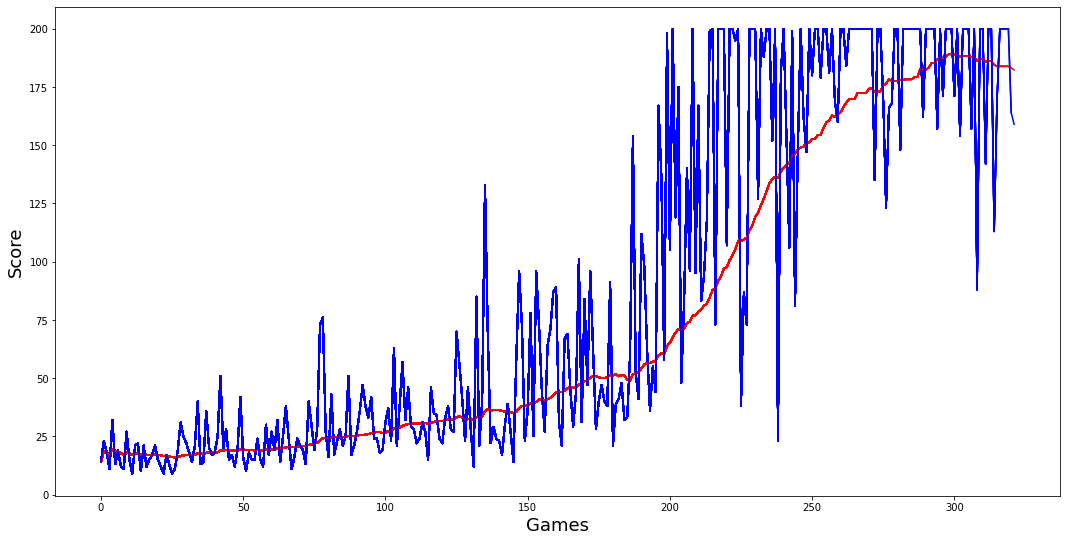

In [1]:
import os
import random
import gym
import time
import pylab
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import cv2
from threading import Thread, Lock
import threading
from threading import Thread, Lock

import vtrace

tfd = tfp.distributions

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class OurModel(tf.keras.Model):
    def __init__(self, input_shape, action_space):
        super(OurModel, self).__init__()
        
        self.dense_0 = Dense(128, activation='relu', kernel_initializer='lecun_normal')
        self.dense_1 = Dense(action_space, kernel_initializer='lecun_normal')
        self.dense_2 = Dense(1, kernel_initializer='lecun_normal')
        
    def call(self, X_input):
        X_input = self.dense_0(X_input)
        action_prob = self.dense_1(X_input)
        value = self.dense_2(X_input)
        
        return action_prob, value


def safe_log(x):
  return tf.where(
      tf.math.equal(x, 0),
      tf.zeros_like(x),
      tf.math.log(tf.math.maximum(1e-12, x)))


def take_vector_elements(vectors, indices):
    return tf.gather_nd(vectors, tf.stack([tf.range(tf.shape(vectors)[0]), indices], axis=1))
    

class IMPALA_Agent:
    def __init__(self, env_name):    
        self.env = gym.make(env_name)
        self.env_name = env_name       
        self.action_size = self.env.action_space.n
        self.EPISODES, self.episode, self.max_average = 200000, 0, 190.0 # specific for cartpole
        
        # Instantiate memory
        memory_size = 5000
        self.memory = []
        self.lock = Lock()

        self.batch_size = 32

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []

        self.Model_name = os.path.join(self.Save_Path, self.env_name + "_IMPALA.h5")
        self.path = '{}_IMPALA'.format(self.env_name)
        
        self.COLS = 4
        
        self.state_size = (self.COLS)
        self.image_memory = np.zeros(self.state_size)
        
        self.model = self.make_model('Model', self.state_size, self.action_size)
        
        #self.model.summary()
        self.learning_rate = 0.001
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
    def remember(self, state, action, policy, reward, next_state, done):
        experience = state, action, policy, reward, next_state, done
        self.memory.append((experience))

    def act(self, state):
        prediction = self.model(state, training=False)
        
        dist = tfd.Categorical(logits=prediction[0])
        action = int(dist.sample()[0])
        policy = prediction[0]
        
        return action, policy
    
    def make_model(self, name, input_shape, action_space):
        state = tf.keras.Input(shape=input_shape)
        head = OurModel(input_shape, action_space)(state)
        model = tf.keras.Model(inputs=state, outputs=head, name=name)
        
        return model
    
    #@tf.function
    def update(self, states, actions, agent_policies, rewards, next_states, dones):
        online_variables = self.model.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(online_variables)
            
            learner_outputs = self.model(states, training=True)
            
            agent_logits = tf.nn.softmax(agent_policies[:-1])
            actions = actions[:-1]
            rewards = rewards[1:]
            dones = dones[1:]
        
            learner_policies = learner_outputs[0]
            learner_logits = tf.nn.softmax(learner_policies[:-1])
            
            learner_values = learner_outputs[1]
            learner_values = tf.squeeze(learner_values)
            
            bootstrap_value = learner_values[-1]
            learner_values = learner_values[:-1]
            
            discounting = 0.99
            discounts = tf.cast(~dones, tf.float32) * discounting
            
            actions = tf.convert_to_tensor(actions, dtype=tf.int32)
                
            target_action_probs = take_vector_elements(learner_logits, actions)
            target_action_log_probs = tf.math.log(target_action_probs)
            
            behaviour_action_probs = take_vector_elements(agent_logits, actions)
            behaviour_action_log_probs = tf.math.log(behaviour_action_probs)
            
            lambda_ = 1.0
            
            log_rhos = target_action_log_probs - behaviour_action_log_probs
            
            log_rhos = tf.convert_to_tensor(log_rhos, dtype=tf.float32)
            discounts = tf.convert_to_tensor(discounts, dtype=tf.float32)
            rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
            values = tf.convert_to_tensor(learner_values, dtype=tf.float32)
            bootstrap_value = tf.convert_to_tensor(bootstrap_value, dtype=tf.float32)
            
            clip_rho_threshold = tf.convert_to_tensor(1.0, dtype=tf.float32)
            clip_pg_rho_threshold = tf.convert_to_tensor(1.0, dtype=tf.float32)
            
            rhos = tf.math.exp(log_rhos)
            
            clipped_rhos = tf.minimum(clip_rho_threshold, rhos, name='clipped_rhos')
            
            cs = tf.minimum(1.0, rhos, name='cs')
            cs *= tf.convert_to_tensor(lambda_, dtype=tf.float32)

            values_t_plus_1 = tf.concat([values[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
            deltas = clipped_rhos * (rewards + discounts * values_t_plus_1 - values)
        
            acc = tf.zeros_like(bootstrap_value)
            vs_minus_v_xs = []
            for i in range(int(discounts.shape[0]) - 1, -1, -1):
                discount, c, delta = discounts[i], cs[i], deltas[i]
                acc = delta + discount * c * acc
                vs_minus_v_xs.append(acc)  
            
            vs_minus_v_xs = vs_minus_v_xs[::-1]
            
            vs = tf.add(vs_minus_v_xs, values, name='vs')
            vs_t_plus_1 = tf.concat([vs[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
            clipped_pg_rhos = tf.minimum(clip_pg_rho_threshold, rhos, name='clipped_pg_rhos')
            
            pg_advantages = (clipped_pg_rhos * (rewards + discounts * vs_t_plus_1 - values))
            
            vs = tf.stop_gradient(vs)
            pg_advantages = tf.stop_gradient(pg_advantages)
            
            actor_loss = -tf.reduce_mean(target_action_log_probs * pg_advantages)
            
            baseline_cost = 0.5
            v_error = values - vs
            critic_loss = baseline_cost * 0.5 * tf.reduce_mean(tf.square(v_error))
            
            total_loss = actor_loss + critic_loss

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
    def replay(self):
        memory_len = len(self.memory)
        if len(self.memory) > self.batch_size:
            start_index = random.randint(0, memory_len - self.batch_size)
            minibatch = self.memory[start_index:start_index+self.batch_size]
        else:
            return

        state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        action = np.zeros(self.batch_size, dtype=np.int32)
        policy = np.zeros((self.batch_size, self.action_size), dtype=np.float32)
        reward = np.zeros(self.batch_size, dtype=np.float32)
        next_state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        done = np.zeros(self.batch_size, dtype=np.bool)
      
        for i in range(len(minibatch)):
            state[i], action[i], policy[i], reward[i], next_state[i], done[i] = minibatch[i]

        self.update(state, action, policy, reward, next_state, done)
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Games', fontsize=18)
        try:
            pylab.savefig(self.env_name + "_IMAPLA.png")
        except OSError:
            pass

        # no need to worry about model, when doing a lot of experiments
        self.Model_name = os.path.join(self.Save_Path, self.env_name + "_IMAPLA.h5")

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow("cartpole" + str(rem_step), image[:,:,rem_step])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
        
    def reset(self, env):
        state = env.reset()
            
        return state

    def step(self, action, env):
        next_state, reward, done, info = env.step(action)
        
        return next_state, reward, done, info
    
    def run(self, n_threads):
        self.env.close()
        
        # Instantiate one environment per thread
        envs = [gym.make(self.env_name) for i in range(n_threads)]

        # Create threads
        threads = [threading.Thread(
                target=self.run_threading,
                daemon=True,
                args=(self,
                    envs[i],
                    i)) for i in range(n_threads)]

        for t in threads:
            time.sleep(2)
            t.start()
            
        for t in threads:
            time.sleep(10)
            t.join()
    
    def run_threading(self, agent, env, thread):
        max_average = 190.0
        total_step = 0
        for e in range(self.EPISODES):
            state = self.reset(env)
            state = np.expand_dims(state, 0)
            
            done = False
            score = 0
            SAVING = ''
            while not done:
                #self.env.render()
                action, policy = self.act(state)
                
                next_state, reward, done, _ = self.step(action, env)
                next_state = np.expand_dims(next_state, 0)
                
                self.remember(state, action, policy, reward / 200.0, next_state, done)
                state = next_state
                score += reward

                if done:           
                    break
                
                self.lock.acquire()
                if total_step % 10 == 0:
                    # train model
                    self.replay()
                self.lock.release()
                    
                total_step += 1
                
            # Update episode count
            with self.lock:
                average = self.PlotModel(score, self.episode)
                # saving best models
                if average >= self.max_average:
                    self.max_average = average
                    #self.save()
                    SAVING = "SAVING"
                else:
                    SAVING = ""

                print("episode: {}/{}, thread: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, thread, score, average, SAVING))
                if(self.episode < self.EPISODES):
                    self.episode += 1
                    
        # close environemnt when finish training
        self.env.close()

    def test(self, Model_name):
        self.load(Model_name)
        for e in range(self.EPISODES):
            state = self.reset()
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
                    
        self.env.close()

        
if __name__ == "__main__":
    env_name = 'CartPole-v0'
    agent = IMPALA_Agent(env_name)
    agent.run(n_threads=4)
    #agent.test('Models/Pong-v0_DDQN_CNN.h5')